# UE22AM342BA2 – Deep Learning on Graph Course Project
## Project Title   :  BiasNet: A Contrastive GNN-Based Framework for Political Stance Detection in News

# 1. Setup and Imports

##### Install necessary libraries (torch_geometric) and import required modules from PyTorch, PyTorch Geometric, Pandas, NumPy, and Scikit-learn. Set random seeds for reproducibility.

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import random
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

## 2. Data Loading and Preprocessing

##### Load the dataset containing article information and pre-computed embeddings. Process the embeddings and prepare node features and labels for the graph.

In [4]:
df = pd.read_csv("dataset/df_with_embeddings.csv")

In [5]:
df["Embedding"] = df["Embedding"].apply(lambda x: np.array(eval(x)) if isinstance(x, str) else x)
df["Embedding"] = df["Embedding"].apply(lambda x: x.astype(np.float32))

In [6]:
embeddings = np.stack(df["Embedding"].to_list())  
emb_dim = embeddings.shape[1]

In [7]:
sources = df["source"].values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
source_onehot = encoder.fit_transform(sources)
source_dim = source_onehot.shape[1]

In [8]:
node_features = np.concatenate([embeddings], axis=1)  
#np.concatenate([embeddings, source_onehot], axis=1) to add source as note feature
node_features = torch.tensor(node_features, dtype=torch.float)

In [9]:
df['bias'].unique()

array(['least', 'left', 'right'], dtype=object)

In [10]:
bias_map = {"left": 0, "right": 1, "least": 2}
labels = df["bias"].map(bias_map).values
labels = torch.tensor(labels, dtype=torch.long)

# 3. Graph Construction

##### Create the graph structure. Nodes represent articles. Edges are added between nodes (articles) if the cosine similarity of their text embeddings exceeds a predefined threshold. This creates a graph where similar articles are connected.

In [11]:
threshold = 0.9
num_nodes = node_features.shape[0]

sim_matrix = cosine_similarity(embeddings)  

edge_list = []
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if sim_matrix[i, j] > threshold:
            edge_list.append([i, j])
            edge_list.append([j, i])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

In [12]:
print(len(edge_list))
print(len(df))

1394980
3832


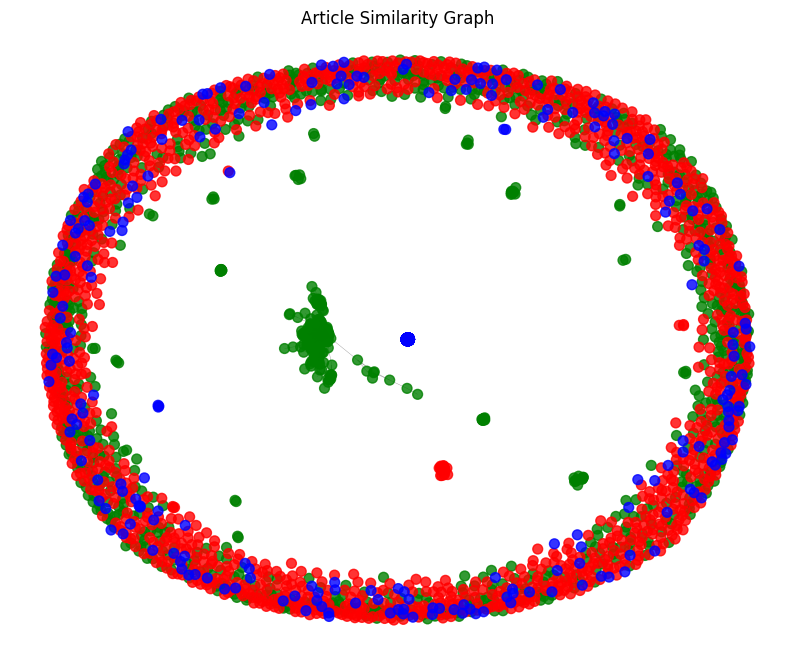

In [62]:
G = nx.Graph()

G.add_nodes_from(range(num_nodes))  
# Add edges
G.add_edges_from(edge_list)

color_map = []
for label in labels.numpy():
    if label == 0:
        color_map.append("red")    # Left
    elif label == 1:
        color_map.append("blue")   # Right
    else:
        color_map.append("green")  # Least

pos = nx.spring_layout(G, seed=42) 

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=50, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.4)
plt.title("Article Similarity Graph")
plt.axis("off")
plt.show()

# 4. Data Splitting (Train/Validation/Test)

##### Split the nodes (articles) into training, validation, and test sets. This is crucial for evaluating the GNN model's performance on unseen data during and after training. We use stratification to ensure that the distribution of bias labels is similar across all splits. Boolean masks are created to easily select nodes belonging to each set.

In [13]:
### ===== Step 3: Train/Val/Test Split =====

# We split node indices (articles) for semi-supervised node classification.
all_indices = np.arange(num_nodes)
train_idx, temp_idx = train_test_split(all_indices, test_size=0.4, random_state=seed, stratify=labels.numpy())
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=seed, stratify=labels[temp_idx].numpy())

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

# 5. Create PyTorch Geometric Data Object

##### Combine node features, edge structure, labels, and masks into a single `Data` object from PyTorch Geometric. This object is the standard input format for PyG models.

In [14]:
data = Data(x=node_features, edge_index=edge_index, y=labels)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Feature dimension:", data.num_node_features)

Graph has 3832 nodes and 1394980 edges.
Feature dimension: 768


# 6. Define GNN Models

Define the architectures for the Graph Neural Network models.
-   **GATConvClassifier**: Uses Graph Attention Network (GAT) layers, which allow nodes to weigh the importance of their neighbors' features.
-   **GCNConvClassifier**: Uses Graph Convolutional Network (GCN) layers, a fundamental GNN layer type based on spectral graph convolutions.

In [15]:
class GATConvClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, heads=4, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # The output dimension will be hidden_channels * heads if concat=True. Here we use concat=True.
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [16]:
class GCNConvClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# 7. Define Training and Evaluation Functions

Create helper functions for the training loop and model evaluation.
-   **train**: Performs one epoch of training (forward pass, loss calculation, backpropagation, optimizer step).
-   **evaluate**: Calculates model accuracy on the training, validation, and test sets.

In [17]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [18]:
@torch.no_grad()
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = {}
    for split, mask in zip(["Train", "Val", "Test"], [data.train_mask, data.val_mask, data.test_mask]):
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs[split] = acc
    return accs

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 8. Train and Evaluate GAT Model (Model 1)

##### Instantiate the GAT model, define the optimizer (Adam) and loss function (Negative Log Likelihood Loss), and run the training loop. Print evaluation metrics periodically and at the end of training.

In [20]:
model1 = GATConvClassifier(in_channels=data.num_node_features,
                      hidden_channels=64,
                      num_classes=3,
                      heads=4,
                      dropout=0.6).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [21]:
num_epochs = 100
for epoch in range(1, num_epochs+1):
    loss = train(model1, data, optimizer, criterion)
    if epoch % 10 == 0:
        accs = evaluate(model1, data)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {accs['Train']:.4f}, Val: {accs['Val']:.4f}, Test: {accs['Test']:.4f}")

accs1 = evaluate(model1, data)
print("Final Accuracy:")
print("Train: {:.4f}, Val: {:.4f}, Test: {:.4f}".format(accs1["Train"], accs1["Val"], accs1["Test"]))

Epoch 010, Loss: 0.5473, Train: 0.8969, Val: 0.9086, Test: 0.8970
Epoch 020, Loss: 0.4930, Train: 0.9195, Val: 0.9217, Test: 0.9179
Epoch 030, Loss: 0.4428, Train: 0.9230, Val: 0.9334, Test: 0.9179
Epoch 040, Loss: 0.4233, Train: 0.9221, Val: 0.9334, Test: 0.9179
Epoch 050, Loss: 0.4350, Train: 0.9252, Val: 0.9334, Test: 0.9218
Epoch 060, Loss: 0.4315, Train: 0.9217, Val: 0.9282, Test: 0.9166
Epoch 070, Loss: 0.4331, Train: 0.9282, Val: 0.9321, Test: 0.9231
Epoch 080, Loss: 0.4495, Train: 0.9204, Val: 0.9243, Test: 0.9192
Epoch 090, Loss: 0.4449, Train: 0.9269, Val: 0.9334, Test: 0.9179
Epoch 100, Loss: 0.4178, Train: 0.9374, Val: 0.9373, Test: 0.9257
Final Accuracy:
Train: 0.9374, Val: 0.9373, Test: 0.9257


# 9. Train and Evaluate GCN Model (Model 2)

##### Instantiate the GCN model, define the optimizer and loss function, and run the training loop. Print evaluation metrics periodically and at the end of training.

In [22]:
model2 = GCNConvClassifier(in_channels=data.num_node_features,
                      hidden_channels=64,
                      num_classes=3,
                      dropout=0.5).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()

In [23]:
for epoch in range(1, num_epochs+1):
    loss = train(model2, data, optimizer, criterion)
    if epoch % 10 == 0:
        accs = evaluate(model2, data)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {accs['Train']:.4f}, Val: {accs['Val']:.4f}, Test: {accs['Test']:.4f}")

# Final evaluation
accs2 = evaluate(model2, data)
print("Final Accuracy:")
print("Train: {:.4f}, Val: {:.4f}, Test: {:.4f}".format(accs2["Train"], accs2["Val"], accs2["Test"]))

Epoch 010, Loss: 0.3227, Train: 0.8778, Val: 0.8851, Test: 0.8827
Epoch 020, Loss: 0.2299, Train: 0.9243, Val: 0.9230, Test: 0.9231
Epoch 030, Loss: 0.1803, Train: 0.9452, Val: 0.9399, Test: 0.9322
Epoch 040, Loss: 0.1575, Train: 0.9617, Val: 0.9386, Test: 0.9387
Epoch 050, Loss: 0.1358, Train: 0.9717, Val: 0.9439, Test: 0.9465
Epoch 060, Loss: 0.1110, Train: 0.9852, Val: 0.9439, Test: 0.9452
Epoch 070, Loss: 0.0958, Train: 0.9922, Val: 0.9373, Test: 0.9531
Epoch 080, Loss: 0.0924, Train: 0.9943, Val: 0.9373, Test: 0.9505
Epoch 090, Loss: 0.0888, Train: 0.9970, Val: 0.9439, Test: 0.9518
Epoch 100, Loss: 0.0826, Train: 0.9978, Val: 0.9399, Test: 0.9426
Final Accuracy:
Train: 0.9978, Val: 0.9399, Test: 0.9426


# 10. Contrastive Learning Setup

-   **GCNWithContrastive**: Extends the GCN model with a "projection head" that maps the GNN's output embeddings into a space suitable for contrastive loss calculation.
-   **nt_xent_loss**: Implements the Normalized Temperature-scaled Cross Entropy (NT-Xent) loss, a common contrastive loss function. It encourages similarity between "positive pairs" (nodes with the same label in a batch) and dissimilarity between "negative pairs" (nodes with different labels).
-   **train_with_contrastive**: A modified training function that calculates both the standard classification loss (NLLLoss) and the contrastive loss (NT-Xent) and combines them using a contrastive_weight.

In [24]:
class GCNWithContrastive(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5, projection_dim=128):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Main classifier
        self.fc = torch.nn.Linear(hidden_channels, num_classes)
        
        # Projection head for contrastive learning
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, projection_dim)
        )
        
        self.dropout = dropout

    def forward(self, x, edge_index, return_embeddings=False):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        # Node embeddings after GCN layers
        embeddings = F.relu(x)
        
        # Project embeddings for contrastive learning
        projections = self.projection(embeddings)
        projections = F.normalize(projections, p=2, dim=1)
        
        # Class predictions
        logits = self.fc(embeddings)
        out = F.log_softmax(logits, dim=1)
        
        if return_embeddings:
            return out, embeddings, projections
        return out


In [25]:
# Contrastive loss function (NT-Xent loss)
def nt_xent_loss(projections, labels, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy Loss
    projections: node embeddings from projection head [batch_size, projection_dim]
    labels: node labels [batch_size]
    temperature: temperature parameter
    """
    # Gather embeddings of nodes with same labels
    device = projections.device
    batch_size = projections.shape[0]
    
    # Create mask for positive pairs (same label)
    mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float()
    
    # Remove self-comparisons
    mask = mask - torch.eye(batch_size, device=device)
    
    # Compute similarity matrix
    sim_matrix = torch.mm(projections, projections.t()) / temperature
    
    # For numerical stability
    sim_matrix_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
    sim_matrix = sim_matrix - sim_matrix_max.detach()
    
    # Compute exp of similarities
    exp_sim = torch.exp(sim_matrix)
    
    # Compute denominator (sum over all except self)
    mask_sum = mask.sum(dim=1)
    mask_sum[mask_sum == 0] = 1  # Avoid division by zero
    
    # Log of mean exp similarity of positive pairs
    pos_sim = (mask * exp_sim).sum(dim=1) / mask_sum
    pos_sim = torch.log(pos_sim + 1e-8)
    
    # Compute denominator (sum over all except self)
    neg_sim = torch.log(exp_sim.sum(dim=1) - exp_sim.diag() + 1e-8)
    
    # Compute final loss
    loss = -(pos_sim - neg_sim).mean()
    
    return loss

In [26]:
def train_with_contrastive(model, data, optimizer, classification_criterion, contrastive_weight=0.5):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with embeddings and projections
    out, _, projections = model(data.x, data.edge_index, return_embeddings=True)
    
    # Classification loss
    class_loss = classification_criterion(out[data.train_mask], data.y[data.train_mask])
    
    # Contrastive loss (only for training nodes)
    train_projections = projections[data.train_mask]
    train_labels = data.y[data.train_mask]
    
    # Only compute contrastive loss if we have enough training samples
    if train_projections.shape[0] > 1:
        contrast_loss = nt_xent_loss(train_projections, train_labels)
        total_loss = class_loss + contrastive_weight * contrast_loss
    else:
        total_loss = class_loss
    
    total_loss.backward()
    optimizer.step()
    
    return total_loss.item()

# 11. Train and Evaluate GCN with Contrastive Loss (Model 3)

##### Instantiate the GCNWithContrastive model, define optimizer and criterion, and train using the train_with_contrastive function. Evaluate performance.

In [27]:
model3 = GCNWithContrastive(
    in_channels=data.num_node_features,
    hidden_channels=64,
    num_classes=3,
    dropout=0.5,
    projection_dim=128  # Dimension for contrastive projections
).to(device)

optimizer = torch.optim.Adam(model3.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()


In [28]:
contrastive_weight = 0.5 

for epoch in range(1, num_epochs+1):
    loss = train_with_contrastive(model3, data, optimizer, criterion, contrastive_weight)
    
    if epoch % 10 == 0:
        accs = evaluate(model3, data)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {accs['Train']:.4f}, Val: {accs['Val']:.4f}, Test: {accs['Test']:.4f}")

accs3 = evaluate(model3, data)
print("Final Accuracy:")
print(f"Train: {accs3['Train']:.4f}, Val: {accs3['Val']:.4f}, Test: {accs3['Test']:.4f}")

Epoch 010, Loss: 3.8752, Train: 0.8826, Val: 0.8890, Test: 0.8840
Epoch 020, Loss: 3.7059, Train: 0.9304, Val: 0.9256, Test: 0.9205
Epoch 030, Loss: 3.6379, Train: 0.9452, Val: 0.9334, Test: 0.9348
Epoch 040, Loss: 3.5969, Train: 0.9643, Val: 0.9360, Test: 0.9374
Epoch 050, Loss: 3.5583, Train: 0.9756, Val: 0.9386, Test: 0.9374
Epoch 060, Loss: 3.5234, Train: 0.9843, Val: 0.9426, Test: 0.9452
Epoch 070, Loss: 3.5122, Train: 0.9887, Val: 0.9413, Test: 0.9544
Epoch 080, Loss: 3.5080, Train: 0.9935, Val: 0.9465, Test: 0.9492
Epoch 090, Loss: 3.5105, Train: 0.9970, Val: 0.9360, Test: 0.9505
Epoch 100, Loss: 3.4942, Train: 0.9974, Val: 0.9413, Test: 0.9492
Final Accuracy:
Train: 0.9974, Val: 0.9413, Test: 0.9492


## 12. Define and Train GAT with Contrastive Loss (Model 4)

Define a GAT model incorporating contrastive learning.

**Note:** The provided GATWithContrastive class definition currently uses GCNConv layers instead of GATConv layers. This seems like a copy-paste error from the GCNWithContrastive class. For this documentation, I will proceed assuming the *intent* was to use GAT layers, but the code as written implements a GCN with a contrastive head (identical to Model 3's architecture). If you intend to use GAT layers, you should replace GCNConv with GATConv in the GATWithContrastive class definition, adjusting input/output dimensions and parameters  accordingly.

Train this model using the contrastive training loop.

In [29]:
class GATWithContrastive(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5, projection_dim=128):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Main classifier
        self.fc = torch.nn.Linear(hidden_channels, num_classes)
        
        # Projection head for contrastive learning
        self.projection = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, projection_dim)
        )
        
        self.dropout = dropout

    def forward(self, x, edge_index, return_embeddings=False):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)

        # Node embeddings after GCN layers
        embeddings = F.relu(x)
        
        # Project embeddings for contrastive learning
        projections = self.projection(embeddings)
        projections = F.normalize(projections, p=2, dim=1)
        
        # Class predictions
        logits = self.fc(embeddings)
        out = F.log_softmax(logits, dim=1)
        
        if return_embeddings:
            return out, embeddings, projections
        return out


In [30]:
model4 = GATWithContrastive(
    in_channels=data.num_node_features,
    hidden_channels=64,
    num_classes=3,
    dropout=0.5,
    projection_dim=128  # Dimension for contrastive projections
).to(device)

optimizer = torch.optim.Adam(model4.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.NLLLoss()


In [31]:
contrastive_weight = 0.5 

for epoch in range(1, num_epochs+1):
    loss = train_with_contrastive(model4, data, optimizer, criterion, contrastive_weight)
    
    if epoch % 10 == 0:
        accs = evaluate(model4 ,data)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {accs['Train']:.4f}, Val: {accs['Val']:.4f}, Test: {accs['Test']:.4f}")

accs4 = evaluate(model4, data)
print("Final Accuracy:")
print(f"Train: {accs4['Train']:.4f}, Val: {accs4['Val']:.4f}, Test: {accs4['Test']:.4f}")

Epoch 010, Loss: 3.8487, Train: 0.8895, Val: 0.8943, Test: 0.8931
Epoch 020, Loss: 3.7023, Train: 0.9317, Val: 0.9269, Test: 0.9218
Epoch 030, Loss: 3.6462, Train: 0.9482, Val: 0.9334, Test: 0.9322
Epoch 040, Loss: 3.5960, Train: 0.9643, Val: 0.9347, Test: 0.9361
Epoch 050, Loss: 3.5700, Train: 0.9769, Val: 0.9347, Test: 0.9387
Epoch 060, Loss: 3.5355, Train: 0.9852, Val: 0.9426, Test: 0.9492
Epoch 070, Loss: 3.5138, Train: 0.9883, Val: 0.9386, Test: 0.9439
Epoch 080, Loss: 3.4987, Train: 0.9978, Val: 0.9386, Test: 0.9465
Epoch 090, Loss: 3.4778, Train: 0.9991, Val: 0.9399, Test: 0.9518
Epoch 100, Loss: 3.4720, Train: 0.9987, Val: 0.9413, Test: 0.9478
Final Accuracy:
Train: 0.9987, Val: 0.9413, Test: 0.9478


# 13. Results Summary

##### Compare the performance (Train, Validation, Test Accuracy) of all trained models in a table format.

In [32]:
from tabulate import tabulate

results = [
    ['GAT', accs1['Train'], accs1['Val'], accs1['Test']],
    ['GCN', accs2['Train'], accs2['Val'], accs2['Test']],
    ['GCN with Contrastive Learning', accs3['Train'], accs3['Val'], accs3['Test']],
    ['GAT with Contrastive Learning', accs4['Train'], accs4['Val'], accs4['Test']]
]

print(tabulate(results, headers=["Model", "Train Acc", "Val Acc", "Test Acc"], floatfmt=".4f"))

Model                            Train Acc    Val Acc    Test Acc
-----------------------------  -----------  ---------  ----------
GAT                                 0.9374     0.9373      0.9257
GCN                                 0.9978     0.9399      0.9426
GCN with Contrastive Learning       0.9974     0.9413      0.9492
GAT with Contrastive Learning       0.9987     0.9413      0.9478


# 14. Example Prediction for a Single Node

##### Demonstrate how to use the trained models to predict the bias for a specific article (node) from the original dataset.

In [33]:
bias_labels = {0: "Left", 1: "Right", 2: "Least"}
idx = 15
models = [model1, model2, model3, model4]  # List of models

x = data.x.to(device)
edge_index = data.edge_index.to(device)

for i, model in enumerate(models, 1):
    model.eval()
    with torch.no_grad():
        logits = model(x, edge_index)
        pred = torch.argmax(logits[idx]).item()
    print(f"Model {i} Prediction for Article {idx+1}: {bias_labels[pred]}")

Model 1 Prediction for Article 16: Least
Model 2 Prediction for Article 16: Least
Model 3 Prediction for Article 16: Least
Model 4 Prediction for Article 16: Least


# 15. Testing on Unseen Recent Articles

This section implements a pipeline to test the trained models on new articles fetched directly from URLs.

1.  **extract_text_from_url**: Fetches the HTML content of a URL and extracts paragraph text using BeautifulSoup. Includes basic error handling and a user-agent header.
2.  **get_embedding**: Takes raw text and uses a pre-trained sentence transformer model (LaBSE) to generate a fixed-size embedding vector. This function handles tokenization, model inference, and normalization.
3.  **predict_bias**: Orchestrates the prediction process for a new URL:
    * Extracts text from the URL.
    * Generates an embedding for the text.
    * Calculates the cosine similarity between the new article's embedding and the embeddings of all articles in the original graph.
    * Identifies existing nodes (articles) that are similar to the new article based on the threshold.
    * *Temporarily* adds the new article as a node to the graph. Adds edges connecting the new node to its similar neighbors found in the previous step. If no similar nodes are found, it adds a self-loop (connects the node to itself) to allow the GNN to process it.
    * Runs the forward pass of the provided GNN model on this augmented graph (original nodes + new node + new edges).
    * Extracts and returns the predicted bias label for the *new* node.
4.  **Load Embedding Model**: Loads the LaBSE tokenizer and model.
5.  **Prediction Loop**: Iterates through a list of test URLs, calls predict_bias for each URL using each of the trained models, and displays the results in a table.
6.  Getting Ground truth for given article urls from **https://www.allsides.com/bias-checker**

In [45]:
import requests
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F

def extract_text_from_url(url):
    """Extract text content from a URL."""
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        text = '\n'.join(p.get_text(strip=True) for p in paragraphs)
        return text if text else "No text extracted"
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

def get_embedding(text, tokenizer, embedding_model):

    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=64, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    with torch.no_grad():
        model_output = embedding_model(**encoded_input)
    
    embedding = F.normalize(model_output.pooler_output).squeeze(0)
    return embedding

def predict_bias(url, gat_model, tokenizer, embedding_model, existing_embeddings):

    text = extract_text_from_url(url)
    if text is None:
        return None
    
    new_embedding = get_embedding(text, tokenizer, embedding_model)
    
    similarities = F.cosine_similarity(
        new_embedding.unsqueeze(0).to(device),
        existing_embeddings.to(device)
    )
    
    edge_indices = torch.nonzero(similarities > threshold).squeeze()
    
    if len(edge_indices.shape) == 0:  
        print("No similar articles found. Prediction may be less reliable.")
        edge_indices = torch.tensor([], dtype=torch.long)
    
    num_existing_nodes = existing_embeddings.shape[0]
    new_node_idx = num_existing_nodes
    
    new_edges = []
    for idx in edge_indices:
        new_edges.extend([[new_node_idx, idx.item()], [idx.item(), new_node_idx]])
    
    if not new_edges:  
        new_edges = [[new_node_idx, new_node_idx]]
    
    edge_index = torch.tensor(new_edges, dtype=torch.long).t().contiguous()
    
    x = torch.cat([existing_embeddings, new_embedding.unsqueeze(0)], dim=0)
    
    gat_model.eval()
    with torch.no_grad():
        out = gat_model(x.to(device), edge_index.to(device))
        pred = out[new_node_idx].argmax().item()
    
    return bias_labels[pred]

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
embedding_model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru").to(device)

In [59]:
urls=["https://www.theguardian.com/environment/2025/apr/11/global-climate-action-casualty-trump-tariffs",
      "https://www.foxnews.com/politics/supreme-court-blocks-new-deportations-venezuelans-texas-under-18th-century-alien-enemies-act",
     "https://www.theguardian.com/commentisfree/2025/apr/20/as-a-kid-i-hated-easter-because-nothing-happened-now-i-treasure-its-stillness-and-strange-beauty",
     "https://www.newsweek.com/dozens-tourists-killed-terror-attack-during-jd-vance-visit-india-2062563"]

groundtruths = ["Left", "Right", "Left", "Least"]

In [60]:
from tabulate import tabulate

def shorten_url(url, max_len=50):
    return url if len(url) <= max_len else url[:max_len] + "..."

headers = ["URL", "Ground Truth", "Model 1", "Model 2", "Model 3", "Model 4"]

results = []
for i, url in enumerate(urls):
    row = [shorten_url(url), groundtruths[i]]  
    for model in models:
        pred = predict_bias(url, model, tokenizer, embedding_model, data.x)
        row.append(pred)
    results.append(row)

print(tabulate(results, headers=headers, tablefmt="fancy_grid", stralign="center"))


╒═══════════════════════════════════════════════════════╤════════════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│                          URL                          │  Ground Truth  │  Model 1  │  Model 2  │  Model 3  │  Model 4  │
╞═══════════════════════════════════════════════════════╪════════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ https://www.theguardian.com/environment/2025/apr/1... │      Left      │   Left    │   Left    │   Left    │   Left    │
├───────────────────────────────────────────────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ https://www.foxnews.com/politics/supreme-court-blo... │     Right      │   Right   │   Right   │   Right   │   Right   │
├───────────────────────────────────────────────────────┼────────────────┼───────────┼───────────┼───────────┼───────────┤
│ https://www.theguardian.com/commentisfree/2025/apr... │      Left      │   Left    │   Left    │   Left    │   Least   │
├───────────────